In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
import joblib

warnings.filterwarnings('ignore')

In [291]:
# Metrics
def print_metrics(y_true, y_pred):
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2: {r2_score(y_true, y_pred)}')

# Models Comparison

## Testing Set

In [292]:
# Load testing set 
X_train = pd.read_csv('Data_n_model\X_train.csv')
y_train = pd.read_csv('Data_n_model\y_train.csv')
X_test = pd.read_csv('Data_n_model\X_test.csv')
y_test = pd.read_csv('Data_n_model\y_test.csv')

# Load models
lr = joblib.load('Data_n_model/best_lr.pkl')
rf = joblib.load('Data_n_model/best_rf.pkl')
dt = joblib.load('Data_n_model/best_dt.pkl')
gbm = joblib.load('Data_n_model/best_gbm.pkl')
nn = joblib.load('Data_n_model/best_nn.pkl')
xgb = joblib.load('Data_n_model/best_xgb.pkl')
et = joblib.load('Data_n_model/best_et.pkl')
svm = joblib.load('Data_n_model/best_svm.pkl')

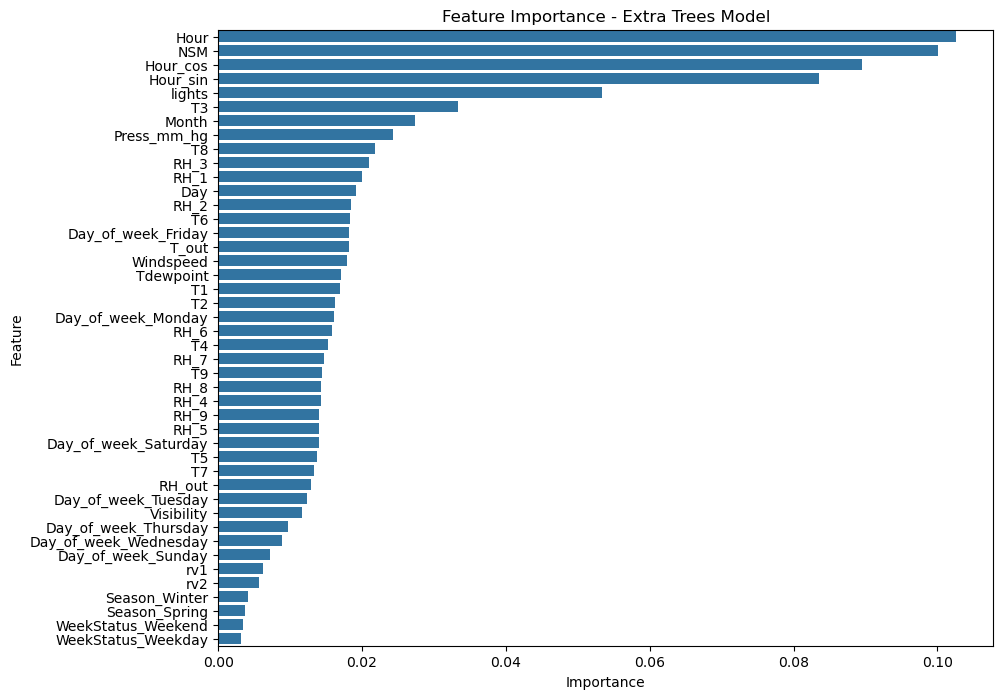

In [293]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import partial_dependence

# Load the best Extra Trees model
best_et = et

# Feature Importance
feature_importances = best_et.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Extra Trees Model')
plt.savefig('Image/Feature Importance.png', dpi=300)
plt.show()

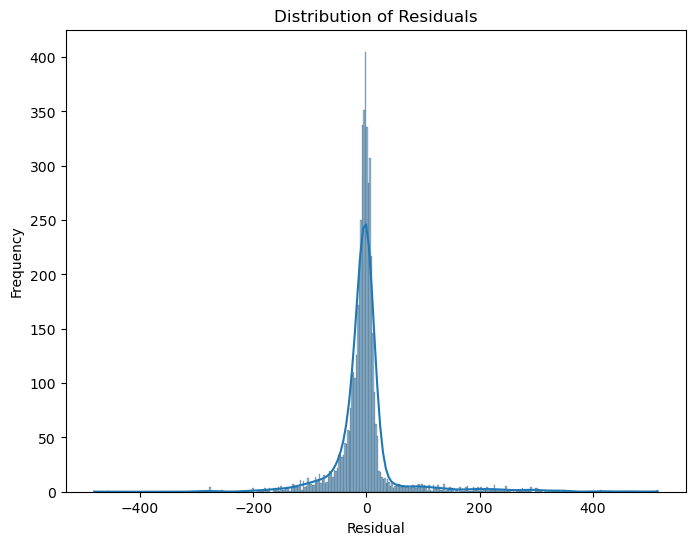

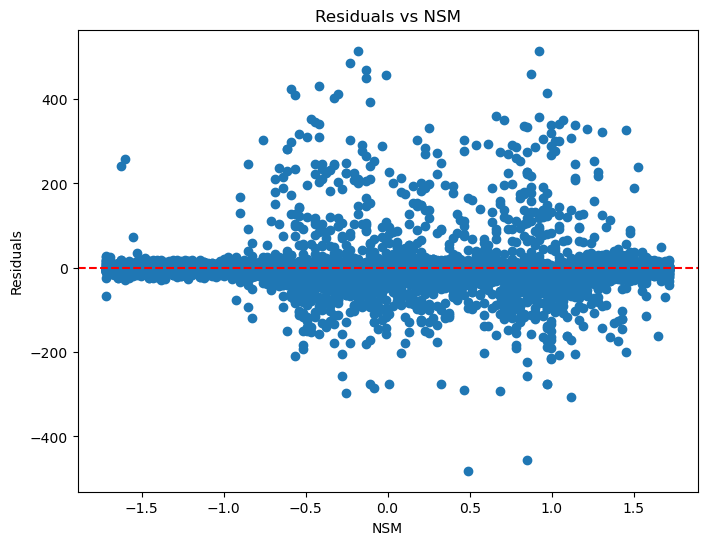

In [285]:
import numpy as np
top_features = importance_df['Feature'].iloc[:6]  # Select top 5 important features

# Predict on the test set
y_pred = et.predict(X_test)

# Calculate the residuals (errors)
residuals = y_test.Appliances - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Analyze errors in relation to one of the top features
top_feature = top_features.iloc[0]
plt.figure(figsize=(8, 6))
plt.scatter(X_test[top_feature], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuals vs {top_feature}')
plt.xlabel(f'{top_feature}')
plt.ylabel('Residuals')
plt.show()

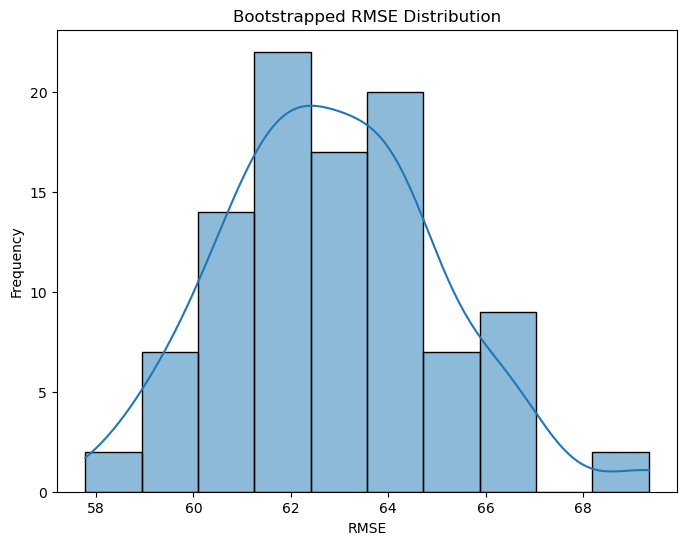

Mean Bootstrapped RMSE: 62.852053775992665
95% Confidence Interval: [59.15423565 66.79857064]


In [287]:
from sklearn.utils import resample

# Bootstrapping to evaluate model stability
n_iterations = 100
n_size = int(len(X_test) * 0.8)

bootstrapped_rmse = []
for i in range(n_iterations):
    # Bootstrap sample
    X_boot, y_boot = resample(X_test, y_test.Appliances, n_samples=n_size)
    
    # Predict and evaluate RMSE
    y_boot_pred = best_et.predict(X_boot)
    rmse = np.sqrt(np.mean((y_boot - y_boot_pred) ** 2))
    bootstrapped_rmse.append(rmse)

# Plot distribution of bootstrapped RMSE scores
plt.figure(figsize=(8, 6))
sns.histplot(bootstrapped_rmse, kde=True)
plt.title('Bootstrapped RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

# Print mean and confidence intervals
print(f'Mean Bootstrapped RMSE: {np.mean(bootstrapped_rmse)}')
print(f'95% Confidence Interval: {np.percentile(bootstrapped_rmse, [2.5, 97.5])}')

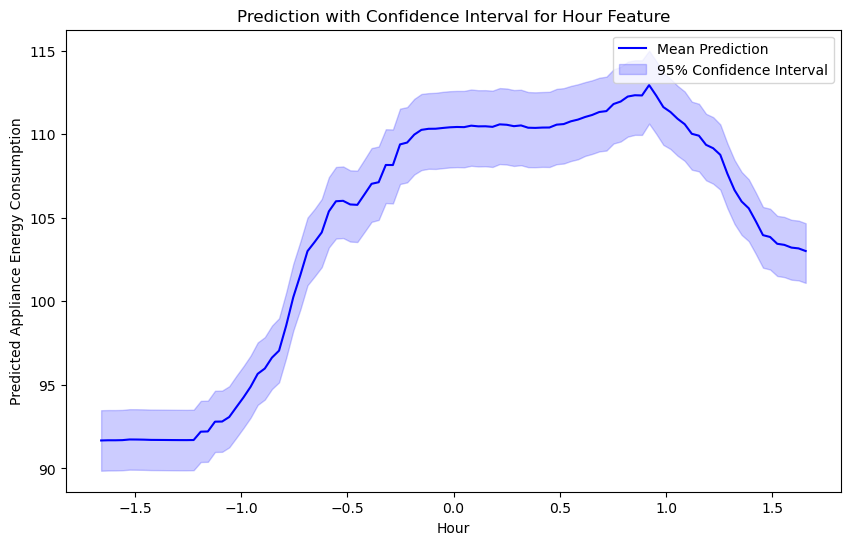

95% Confidence Interval for Predictions at Hour: [[ 89.86054587  89.87410832  89.87717316  89.88919882  89.92350915
  89.91872968  89.91197697  89.89892867  89.89613794  89.89285917
  89.88805127  89.8850897   89.88554799  89.89224889  90.3807246
  90.39313687  90.98153119  90.99044883  91.25920311  91.83017202
  92.41565634  93.02946787  93.79750971  94.11700352  94.74556509
  95.14777381  96.60459127  98.23704834  99.51523409 100.95626265
 101.48466525 102.03957154 103.21290926 103.74894515 103.78229355
 103.57035536 103.54330943 104.14343689 104.74905002 104.86678463
 105.87528251 105.85290931 107.01361748 107.11263255 107.58517333
 107.84568617 107.92527922 107.91575944 107.96271256 108.00491751
 108.02444611 108.01374239 108.10505809 108.06533851 108.07675661
 108.03488956 108.20872124 108.17919738 108.09539315 108.13989887
 108.023136   108.01959805 108.0394746  108.0324592  108.19947788
 108.23947275 108.38944633 108.49334518 108.69544772 108.81465222
 108.96475984 109.01584202 

In [289]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Parameters for bootstrapping
n_iterations = 100
n_size = int(len(X_test) * 0.8)

# Collecting predictions for one feature (e.g., 'Hour')
hour_values = np.linspace(X_test['Hour'].min(), X_test['Hour'].max(), 100)
predictions = []

for i in range(n_iterations):
    # Bootstrap sample
    X_boot, y_boot = resample(X_test, y_test.Appliances, n_samples=n_size)
    
    # Prepare the full feature set, varying only the 'Hour' feature
    X_varied = X_boot.copy()
    
    # Generate predictions for each hour value
    boot_preds = []
    for hour in hour_values:
        X_varied['Hour'] = hour
        boot_preds.append(best_et.predict(X_varied).mean())  # Averaging predictions over the bootstrap sample
    
    predictions.append(boot_preds)

# Convert predictions to a NumPy array for easier manipulation
predictions = np.array(predictions)

# Calculate the mean and confidence intervals
mean_predictions = np.mean(predictions, axis=0)
ci_lower = np.percentile(predictions, 2.5, axis=0)
ci_upper = np.percentile(predictions, 97.5, axis=0)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(hour_values, mean_predictions, label='Mean Prediction', color='blue')
plt.fill_between(hour_values, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('Prediction with Confidence Interval for Hour Feature')
plt.xlabel('Hour')
plt.ylabel('Predicted Appliance Energy Consumption')
plt.legend()
plt.show()

# Print the calculated confidence interval values
print(f'95% Confidence Interval for Predictions at Hour: [{ci_lower}, {ci_upper}]')

In [294]:
# Predict training set
lr_pred_train = lr.predict(X_train)
rf_pred_train = rf.predict(X_train)
svm_pred_train = svm.predict(X_train)
gbm_pred_train = gbm.predict(X_train)
dt_pred_train = dt.predict(X_train)
et_pred_train = et.predict(X_train)
nn_pred_train = nn.predict(X_train)
xgb_pred_train = xgb.predict(X_train)

# Predict testing set
lr_pred_test = lr.predict(X_test)
rf_pred_test = rf.predict(X_test)
svm_pred_test = svm.predict(X_test)
gbm_pred_test = gbm.predict(X_test)
dt_pred_test = dt.predict(X_test)
et_pred_test = et.predict(X_test)
# nn_pred_test = nn.predict(X_test)
# xgb_pred_test = xgb.predict(X_test)

ValueError: X has 44 features, but MLPRegressor is expecting 36 features as input.

In [295]:
model_predictions_train = {
    'LM': lr_pred_train,
    'SVM': svm_pred_train,
    'GBM': gbm_pred_train,
    'RF': rf_pred_train,
    # 'XGB': xgb_pred_train,
    'ET': et_pred_train,
    'DT': dt_pred_train,
    # 'NN': nn_pred_train,
}

model_predictions_test = {
    'LM': lr_pred_test,
    'SVM': svm_pred_test,
    'GBM': gbm_pred_test,
    'RF': rf_pred_test,
    # 'XGB': xgb_pred_test,
    'ET': et_pred_test,
    'DT': dt_pred_test,
    # 'NN': nn_pred_test,
}

# Initialize an empty dictionary to store the metrics
metrics = {}

# Changes
change = ''
# Calculate the metrics for each model using a loop
for model_name in model_predictions_test:
    metrics[change+model_name] = [
        np.sqrt(mean_squared_error(y_train, model_predictions_train[model_name])),
        r2_score(y_train, model_predictions_train[model_name]),
        mean_absolute_error(y_train, model_predictions_train[model_name]),
        mean_absolute_percentage_error(y_train, model_predictions_train[model_name])*100,
        np.sqrt(mean_squared_error(y_test, model_predictions_test[model_name])),
        r2_score(y_test, model_predictions_test[model_name]),
        mean_absolute_error(y_test, model_predictions_test[model_name]),
        mean_absolute_percentage_error(y_test, model_predictions_test[model_name])*100
    ]
# Create DataFrame
metrics_df = pd.DataFrame(metrics, index=['Training RMSE', 'Training R2', 'Training MAE', 'Training MAPE',
                                                      'Testing RMSE', 'Testing R2', 'Testing MAE', 'Testing MAPE'])
metrics_df.T

,Training RMSE,Training R2,Training MAE,Training MAPE,Testing RMSE,Testing R2,Testing MAE,Testing MAPE
LM,91.949632,0.210043,51.892511,58.988512,89.428760,0.194925,51.963393,61.878391
SVM,91.992668,0.209303,36.693244,26.275279,95.955751,0.073119,42.292076,34.327159
GBM,0.348721,0.999989,0.267566,0.435030,81.127155,0.337456,44.756352,50.403064
RF,28.354160,0.924883,14.797550,15.949523,65.109629,0.573251,31.212951,31.421815
ET,66.529185,0.586450,35.295601,38.099252,63.066818,0.599609,29.850750,29.848264
DT,74.508375,0.481303,38.374029,39.892166,82.823814,0.309454,35.536076,31.133706


In [296]:
metrics_df.T.to_csv('metrics_df.csv', index=True)


KeyboardInterrupt



In [297]:
# Original metrics
orig_metrics = pd.read_csv('models_performance.csv', index_col=['models'])

In [298]:
# Difference between the two
diff_metrics = pd.DataFrame(index=orig_metrics.index, columns=orig_metrics.columns)

# Loop through rows and columns
for i in range(6):
    for col in range(len(orig_metrics.columns)):  # Loop over the number of columns
        diff_metrics.iloc[i, col] = orig_metrics.iloc[i, col] - metrics_df.T.iloc[i, col]
for col in diff_metrics:
    if 'R2' in col: 
        diff_metrics[col] = -(diff_metrics[col])

diff_metrics

,Training RMSE,Training R2,Training MAE,Training MAPE %,Testing RMSE,Testing R2,Testing MAE,Testing MAPE %
models,,,,,,,,
LM,1.260368,0.030043,1.237489,2.331488,3.75124,0.034925,0.006607,-1.948391
SVM,-52.642668,-0.640697,-21.613244,-10.675279,-25.215751,-0.446881,-10.932076,-4.567159
GBM,17.211279,0.029989,11.702434,15.83497,-14.477155,-0.232544,-9.536352,-12.113064
RF,1.25584,0.004883,-1.04755,-2.519523,3.370371,0.033251,0.637049,-0.031815
XGB,NaN,NaN,NaN,NaN,0.793182,-0.010391,0.38925,-0.068264
ET,NaN,NaN,NaN,NaN,-23.213814,-0.350546,-8.916076,-5.763706


,Training RMSE,Training R2,Training MAE,Training MAPE %,Testing RMSE,Testing R2,Testing MAE,Testing MAPE %
models,,,,,,,,
LM,2.417888,0.025011,2.232357,2.889974,-0.158885,0.042964,-0.725701,1.179806
SVM,-59.167266,-0.786029,-27.330337,-17.665307,-30.932045,-0.465705,-13.449479,-4.141333
GBM,-19.130558,-0.099829,-9.860476,-11.074841,-9.838293,-0.105232,-6.651114,-6.525386
RF,4.460552,0.019001,1.910696,1.703096,-0.857941,0.02016,-0.929915,0.217198
XGB,NaN,NaN,NaN,NaN,-5.795863,-0.053882,-4.252392,-4.466909
ET,NaN,NaN,NaN,NaN,-19.581642,-0.233735,-14.230521,-16.734855


,Training RMSE,Training R2,Training MAE,Training MAPE %,Testing RMSE,Testing R2,Testing MAE,Testing MAPE %
models,,,,,,,,
LM,2.417888,0.025011,2.232357,2.889974,-0.158885,0.042964,-0.725701,1.179806
SVM,-59.168887,-0.78606,-27.329988,-17.659992,-30.92909,-0.46565,-13.447445,-4.135272
GBM,-22.090347,-0.121621,-10.408418,-9.923394,-6.208319,-0.055636,-0.422681,3.228776
RF,4.383369,0.018626,1.876717,1.671617,-0.923768,0.019325,-0.999382,0.151368
XGB,NaN,NaN,NaN,NaN,-21.674981,-0.27933,-14.461065,-17.690376
ET,NaN,NaN,NaN,NaN,-11.163123,-0.118236,-7.003223,-6.214683
